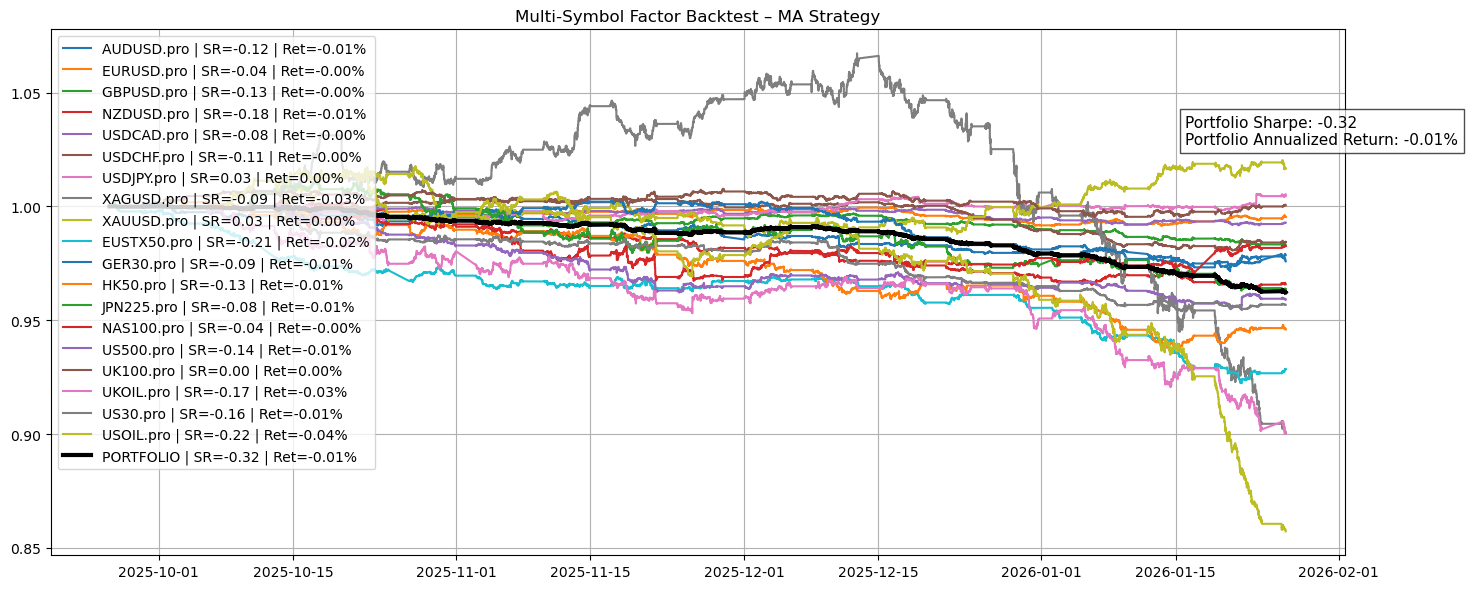

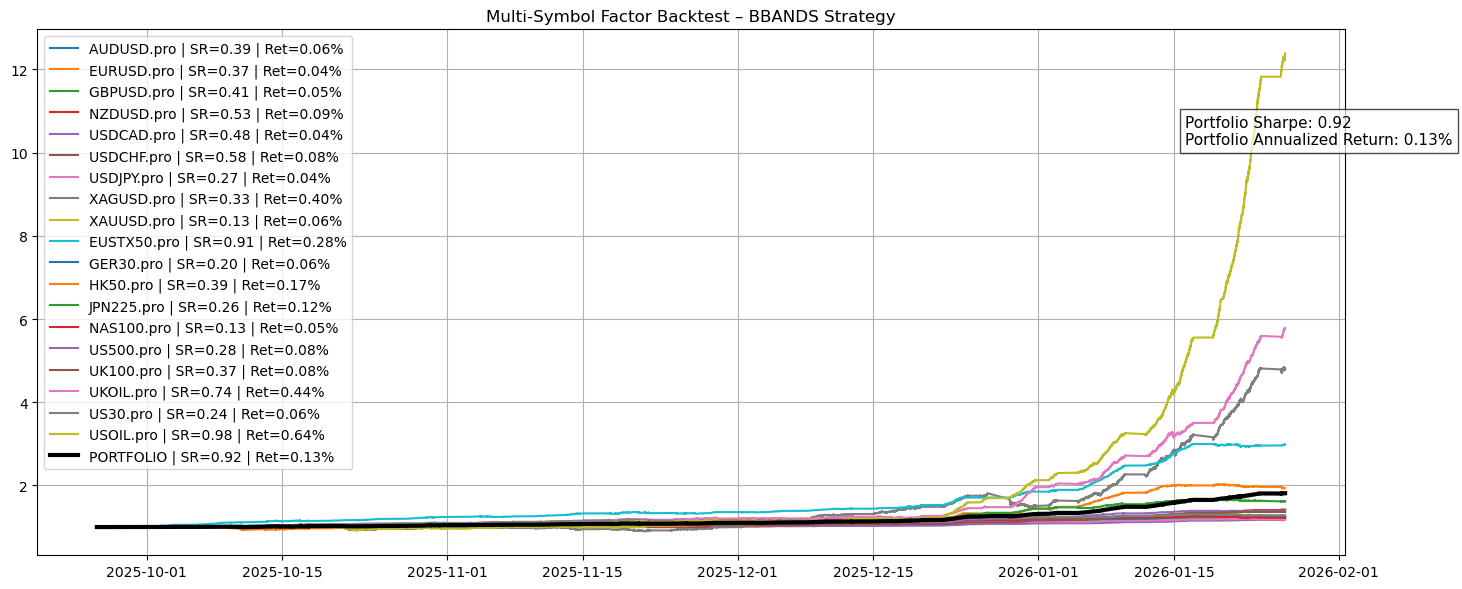

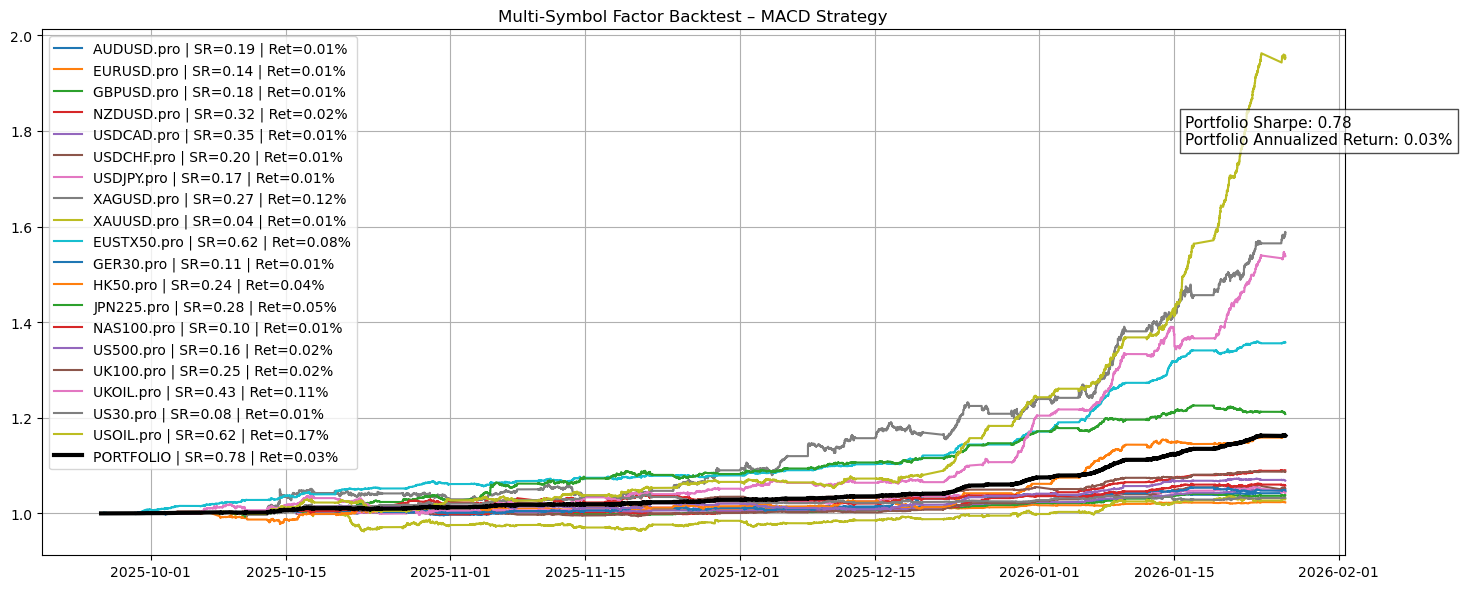

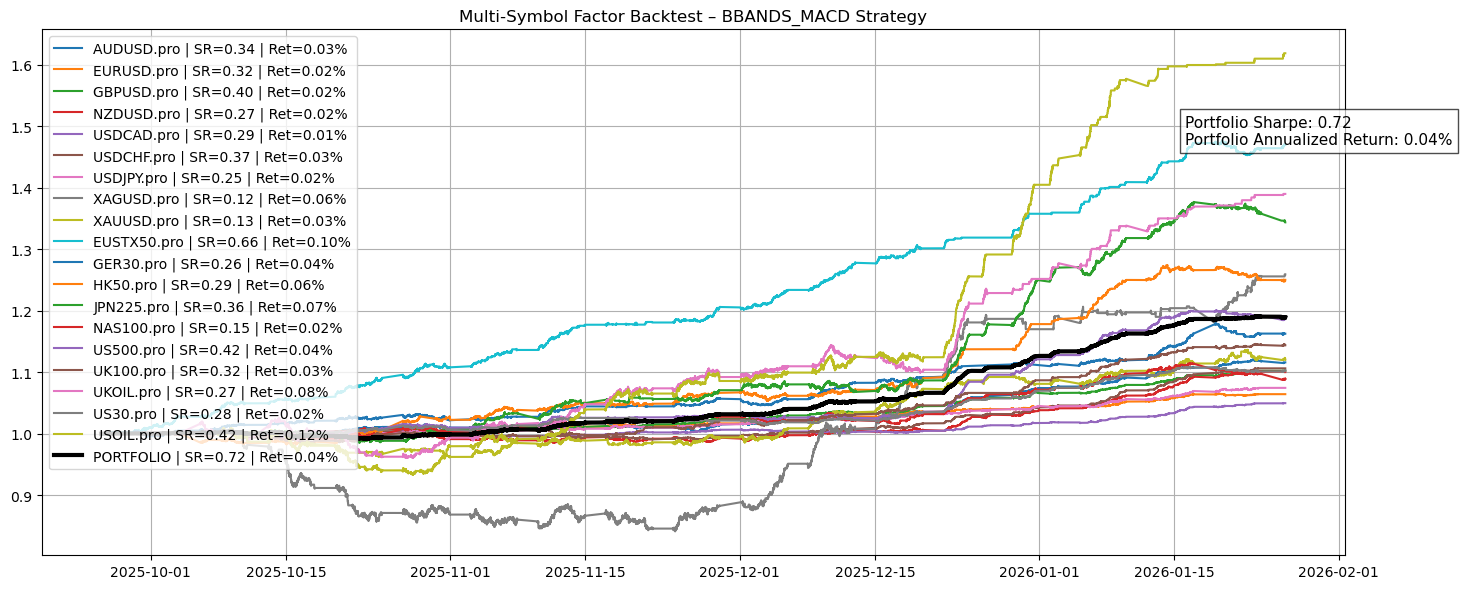

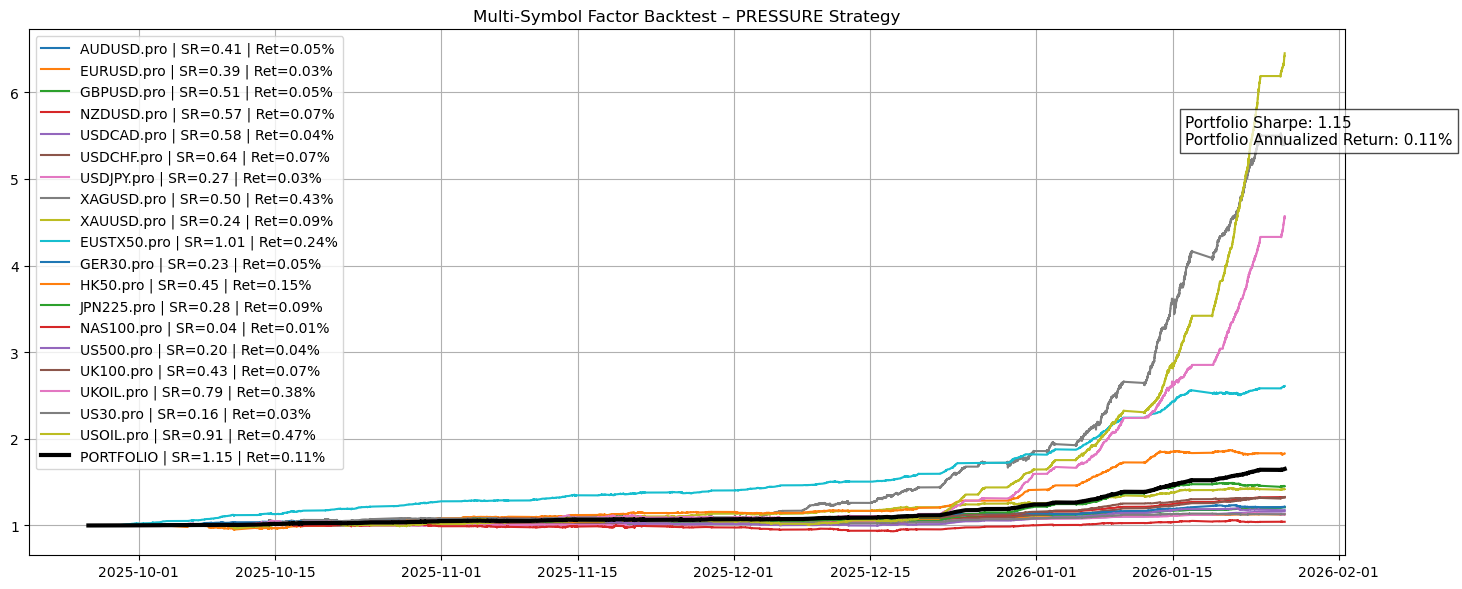

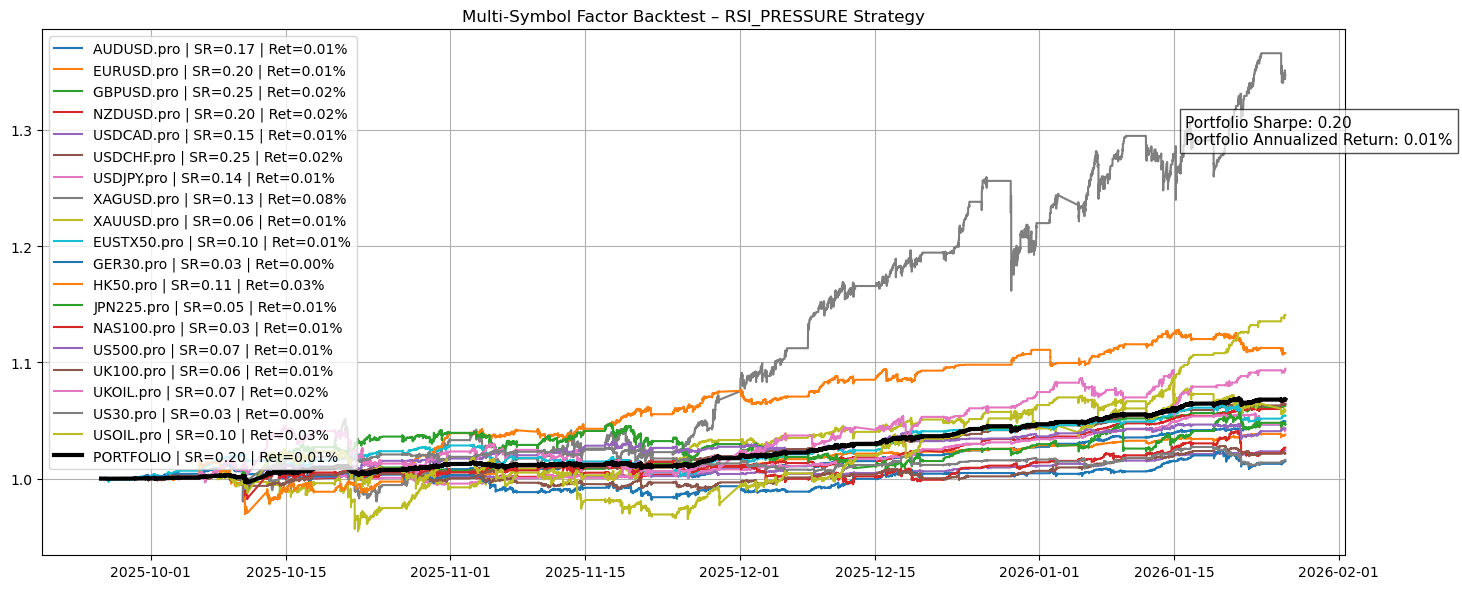

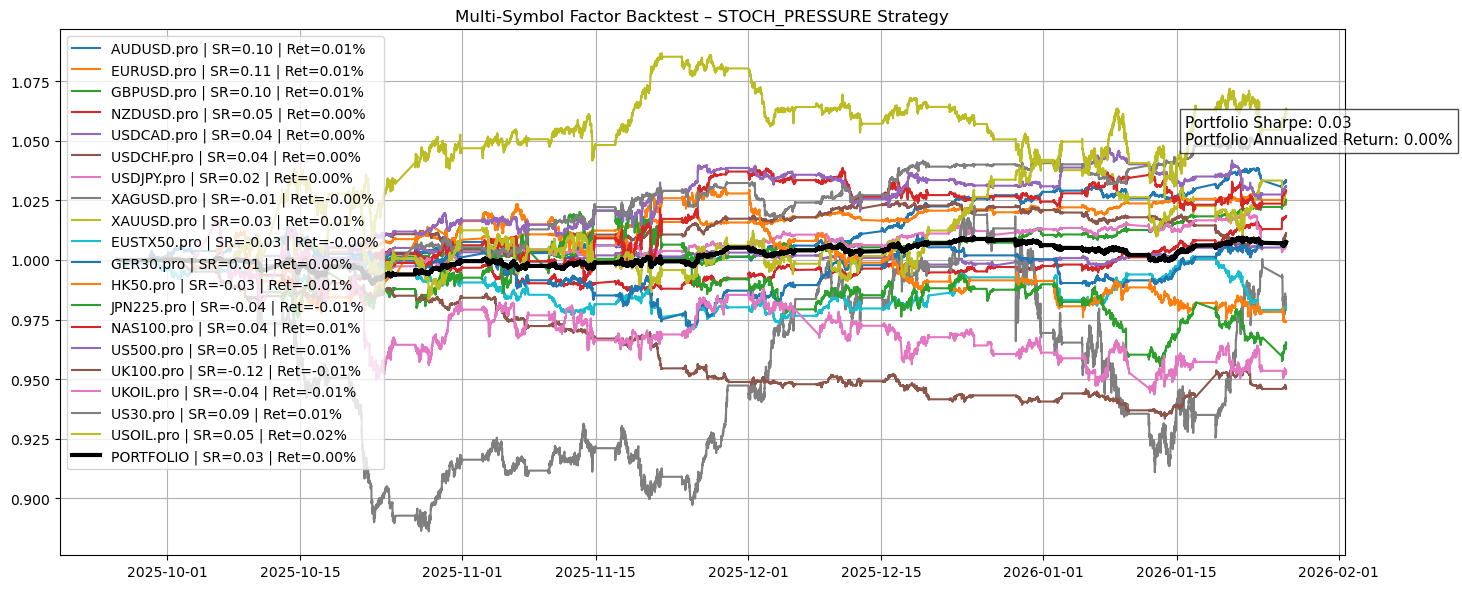

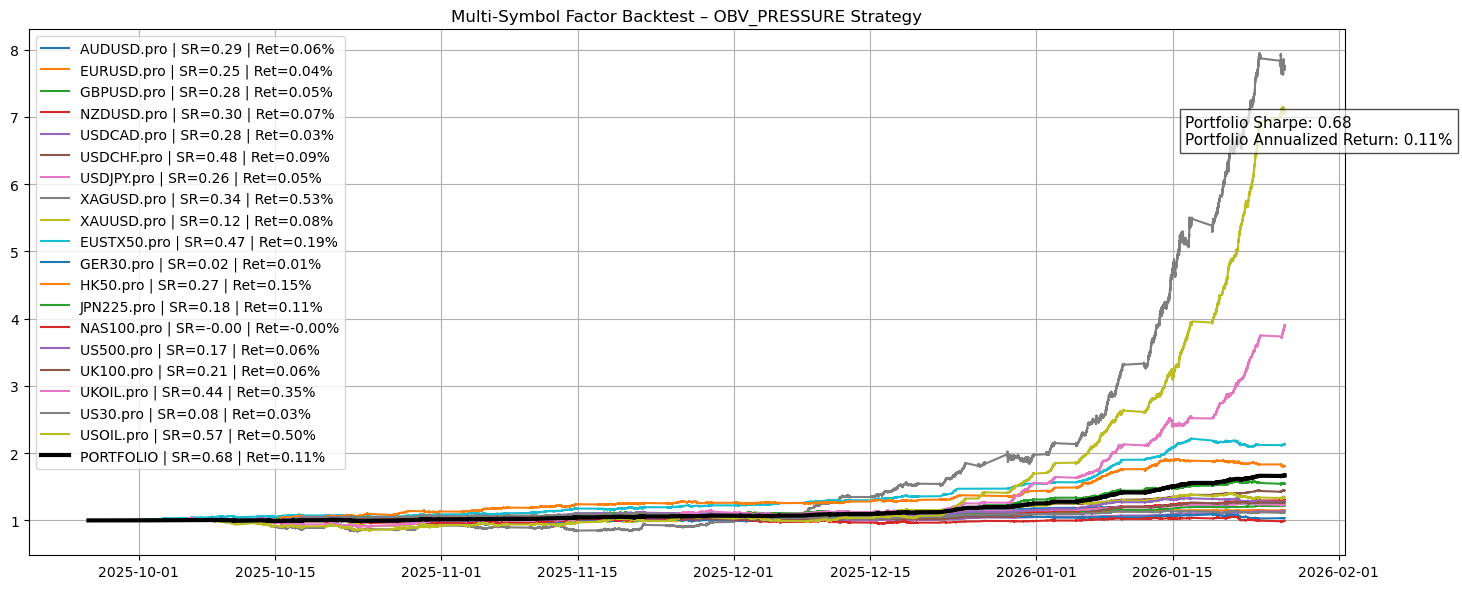

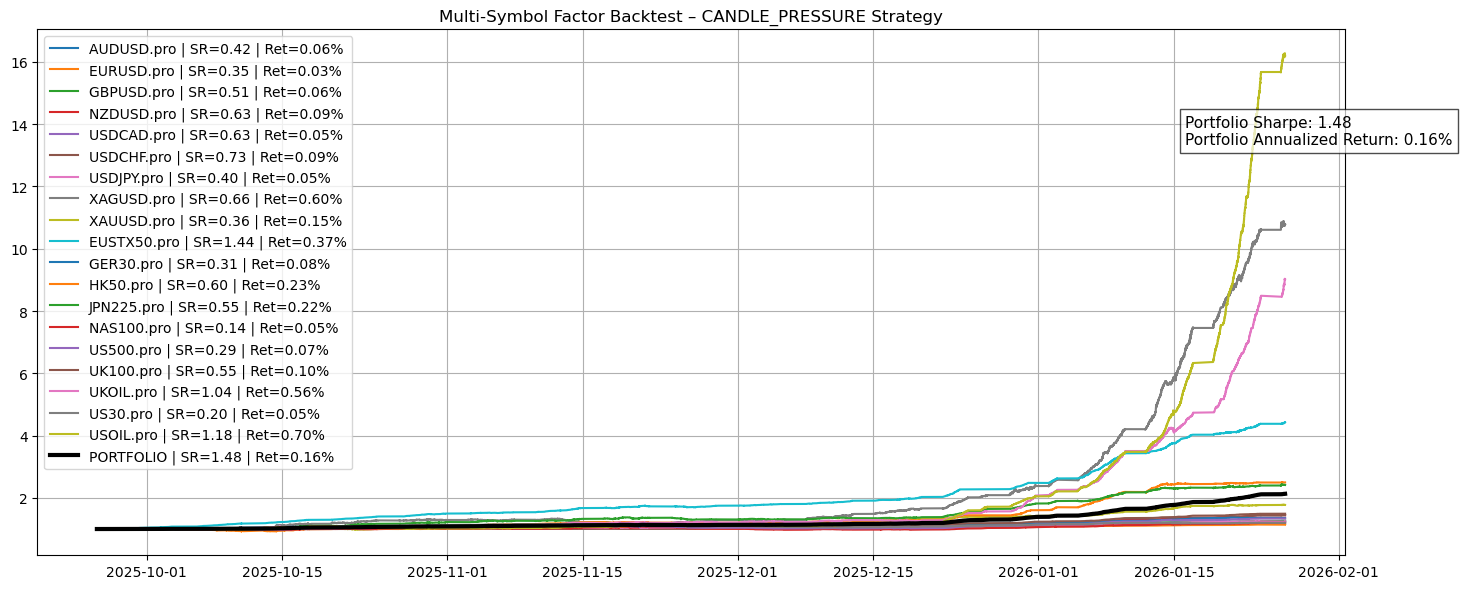

In [ ]:
import MetaTrader5 as mt5
import pandas as pd
from backtest import backtest_symbols
from brokers import get_broker

broker = get_broker("acg")
broker.initialize()



factors = [
    "ma",
    "bbands",
    "macd",
    "bbands_macd",
    "pressure",
    "rsi_pressure",
    "stoch_pressure",
    "obv_pressure",
    "candle_pressure",
    "keltner",
    "adx_trend",
    "cci_reversal",
    "atr_breakout",
    "donchian",
    "cmf_pressure",
    "rsi_vol",
    "volume_spike",
    "vwap_reversion",
    "squeeze_breakout",
    "heikin_ashi",
    "zscore_returns",
    "skew_reversal",
    "rsi_macd_hybrid",
    "pvt_momentum",
]

symbols = pd.read_csv("acg_macro_signal.csv", header=None, sep="\t")[0].tolist()

all_perfs = []   # store only the performance part
timeframe = mt5.TIMEFRAME_M1
for factor in factors:
    perf, _ = backtest_symbols(
        symbols,
        factor=factor,
        timeframe=timeframe
    )
    
    perf["Factor"] = factor.upper()   # tag it
    all_perfs.append(perf)

In [ ]:
import numpy as np
# 1. Combine all performance tables
combined = pd.concat(all_perfs, ignore_index=True)

# 2. Absolute Sharpe
combined["AbsSharpe"] = combined["Sharpe"].abs()

# 3. Select best strategy per symbol (keeps Returns series)
best_per_symbol = combined.loc[
    combined.groupby("Symbol")["AbsSharpe"].idxmax()
].reset_index(drop=True)

print("Best strategy per symbol:")
print(best_per_symbol[["Symbol", "Sharpe", "Factor"]])

# ---------------------------------------------------------
# Build portfolio from selected strategies
# ---------------------------------------------------------

# Extract return series
ret_dict = {
    row["Symbol"]: row["Returns"]
    for _, row in best_per_symbol.iterrows()
}

# Combine into DataFrame
portfolio_df = pd.DataFrame(ret_dict).fillna(0)

# Equal-weight portfolio return
portfolio_ret = portfolio_df.mean(axis=1)

# Portfolio Sharpe
portfolio_sharpe = (
    portfolio_ret.mean() / portfolio_ret.std()
) * np.sqrt(252)

print(f"\nPortfolio Sharpe (best-strategy filter): {portfolio_sharpe:.3f}")

Best strategy per symbol:
         Symbol    Sharpe           Factor
0    AUDUSD.pro  0.417335  CANDLE_PRESSURE
1    EURUSD.pro  0.397555         PRESSURE
2   EUSTX50.pro  1.437557  CANDLE_PRESSURE
3    GBPUSD.pro  0.508004  CANDLE_PRESSURE
4     GER30.pro  0.312800  CANDLE_PRESSURE
5      HK50.pro  0.599133  CANDLE_PRESSURE
6    JPN225.pro  0.543058  CANDLE_PRESSURE
7    NAS100.pro  0.174129          KELTNER
8    NZDUSD.pro  0.641706  CANDLE_PRESSURE
9     UK100.pro  0.546889  CANDLE_PRESSURE
10    UKOIL.pro  1.014406  CANDLE_PRESSURE
11     US30.pro  0.301730          KELTNER
12    US500.pro  0.445501      BBANDS_MACD
13   USDCAD.pro  0.629287  CANDLE_PRESSURE
14   USDCHF.pro  0.785251          KELTNER
15   USDJPY.pro  0.422914  CANDLE_PRESSURE
16    USOIL.pro  1.408562          KELTNER
17   XAGUSD.pro  0.665042  CANDLE_PRESSURE
18   XAUUSD.pro  0.360356  CANDLE_PRESSURE

Portfolio Sharpe (best-strategy filter): 1.747


In [ ]:
import MetaTrader5 as mt5
import pandas as pd 
from factorsignal import generate_signal
from backtest import fetch_mt5_data


symbols = pd.read_csv("acg_macro_signal.csv", header=None, sep="\t")[0].tolist()

df = fetch_mt5_data(symbol=symbols[1], timeframe=mt5.TIMEFRAME_M1)[0]
signal = generate_signal(df, factor=factor)

sig_prev = signal.shift(1)
steps = (signal - sig_prev).abs().fillna(0).astype(int)

counts = steps.value_counts().sort_index()
print(counts)
no_transition = (steps == 0).sum()
one_step      = (steps == 1).sum()
two_steps     = (steps == 2).sum()

print("No transition:", no_transition)
print("1-step transitions:", one_step)
print("2-step transitions:", two_steps)

0    85500
1        1
2    14498
Name: count, dtype: int64
No transition: 85500
1-step transitions: 1
2-step transitions: 14498


In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import talib

def generate_features(df):
    """
    df must contain: ['open','high','low','close','volume']
    returns a DataFrame of continuous ML features
    """

    o = df['open']
    h = df['high']
    l = df['low']
    c = df['close']
    v = df['volume']

    feats = pd.DataFrame(index=df.index)

    # ============================
    # MEAN REVERSION INDICATORS
    # ============================
    feats['rsi_14'] = talib.RSI(c, timeperiod=14)
    feats['stoch_k'], feats['stoch_d'] = talib.STOCH(h, l, c)
    feats['cci_20'] = talib.CCI(h, l, c, timeperiod=20)
    feats['willr_14'] = talib.WILLR(h, l, c, timeperiod=14)
    feats['mfi_14'] = talib.MFI(h, l, c, v, timeperiod=14)

    # Bollinger Bands
    upper, middle, lower = talib.BBANDS(c, timeperiod=20, nbdevup=2, nbdevdn=2)
    feats['bb_width'] = (upper - lower) / middle
    feats['bb_percent'] = (c - lower) / (upper - lower)

    # ============================
    # TREND / CONTINUATION
    # ============================
    feats['ema_20'] = talib.EMA(c, timeperiod=20)
    feats['ema_50'] = talib.EMA(c, timeperiod=50)
    feats['ema_20_50_diff'] = feats['ema_20'] - feats['ema_50']

    macd, macd_signal, macd_hist = talib.MACD(c)
    feats['macd'] = macd
    feats['macd_signal'] = macd_signal
    feats['macd_hist'] = macd_hist

    feats['roc_10'] = talib.ROC(c, timeperiod=10)
    feats['mom_10'] = talib.MOM(c, timeperiod=10)

    # ADX / Aroon
    feats['adx_14'] = talib.ADX(h, l, c, timeperiod=14)
    aroon_down, aroon_up = talib.AROON(h, l, timeperiod=14)
    feats['aroon_up'] = aroon_up
    feats['aroon_down'] = aroon_down

    # ============================
    # VOLATILITY
    # ============================
    feats['atr_14'] = talib.ATR(h, l, c, timeperiod=14)
    feats['natr_14'] = talib.NATR(h, l, c, timeperiod=14)
    feats['std_20'] = talib.STDDEV(c, timeperiod=20)

    # ============================
    # VOLUME / FLOW
    # ============================
    feats['obv'] = talib.OBV(c, v)
    feats['adosc'] = talib.ADOSC(h, l, c, v)

    # ============================
    # RAW PRICE FEATURES
    # ============================
    feats['ret_1'] = c.pct_change()
    feats['ret_5'] = c.pct_change(5)
    feats['ret_10'] = c.pct_change(10)

    # ============================
    # CLEANUP
    # ============================
    feats = (
        feats.replace([np.inf, -np.inf], np.nan)
            .bfill()
            .ffill()
    )

    return feats

import numpy as np
import pandas as pd

def generate_labels(df, threshold=0.001, compress=True):
    """
    df: OHLCV dataframe containing at least 'close'
    threshold: minimum absolute return required to label 1 or -1
    compress: if True, collapse consecutive identical labels into transitions only

    returns: pd.Series of labels {-1, 0, 1}
    """

    # compute future return
    future_ret = df['close'].pct_change(periods=-1)
    # apply threshold
    labels = np.where(
        future_ret > threshold, 1,
        np.where(
            future_ret < -threshold, -1,
            0
        )
    )

    # convert to Series
    
    labels = pd.Series(labels, index=df.index, name="label")
    
    # remove labels where future return is NaN
    labels = labels[future_ret.notna()]

    # ---------------------------------------------------------
    # OPTIONAL: compress consecutive duplicates (state changes)
    # ---------------------------------------------------------
    if compress:
        # True where label changes from previous
        change = labels != labels.shift(1)
        # keep only transitions
        labels = labels[change]
        #labels = labels[labels != 0]   # remove zero labels


    return labels

In [33]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from backtest import fetch_mt5_data



def evaluate_symbol(symbol="EURUSD.pro", timeframe=mt5.TIMEFRAME_M1, stddev=2.5):

    df = fetch_mt5_data(symbol=symbol, timeframe=timeframe)[0]

    threshold = df['close'].pct_change().std() * stddev
    print(f"threshold {symbol}: {threshold:0.2%}")

    # FEATURES + LABELS
    features = generate_features(df)
    return_labels = generate_labels(df=df, threshold=threshold, compress=True)  
    # IMPORTANT: compress=True but generate_labels must return 0 for non-events

    # ALIGN
    common_index = features.index.intersection(return_labels.index)
    features = features.loc[common_index]
    return_labels = return_labels.loc[common_index]

    # LABEL STATS
    total = len(return_labels)
    counts = return_labels.value_counts().to_dict()
    label_stats = {"total": total, "counts": counts}

    # CLEAN
    mask = ~np.isnan(return_labels)
    X = features[mask]
    y = return_labels[mask]   # contains -1, 0, +1

    # ---------------------------------------------------------
    # MAP TRADING LABELS → MODEL LABELS
    # -1 → 0
    #  0 → 1
    # +1 → 2
    # ---------------------------------------------------------
    y_model = y.replace({-1: 0, 0: 1, 1: 2}).astype(int)

    # SPLIT
    X_train, X_val, y_train, y_val = train_test_split(
        X, y_model, test_size=0.2, shuffle=False
    )

    # ---------------------------------------------------------
    # XGBOOST MULTI-CLASS MODEL
    # ---------------------------------------------------------
    model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=1.0,
        reg_lambda=1.0,
        tree_method='hist',
        objective='multi:softprob',   # <--- MULTI-CLASS
        num_class=3                   # <--- 3 CLASSES
    )

    # CLASS WEIGHTS (optional)
    class_weights = {0: 4, 1: 1, 2: 4}  
    # 0 = -1 event, 1 = no event, 2 = +1 event

    sample_weights = np.array([class_weights[label] for label in y_train])

    # TRAIN
    model.fit(X_train, y_train, sample_weight=sample_weights)

    # ---------------------------------------------------------
    # PREDICT (multi-class probabilities)
    # ---------------------------------------------------------
    y_pred_model = model.predict(X_val)

    # MAP BACK TO TRADING LABELS
    inv_map = {0: -1, 1: 0, 2: 1}
    y_pred = np.vectorize(inv_map.get)(y_pred_model)
    y_val_trading = np.vectorize(inv_map.get)(y_val)

    # ACCURACY
    acc = accuracy_score(y_val_trading, y_pred)

    # REPORT
    report = classification_report(y_val_trading, y_pred, output_dict=False)

    return acc, report, label_stats, df

In [34]:

def evaluate_all_symbols(symbol_list, timeframe=mt5.TIMEFRAME_M1, stddev=2.5):
    results = []
    print(f"Evaluating...")
    for sym in symbol_list:
        #
        try:
            acc, report, label_stats, _ = evaluate_symbol(symbol=sym, timeframe=timeframe, stddev=stddev)
            
            results.append({
                "symbol": sym,
                "accuracy": acc,
                "report": report,
                "label_stats": label_stats
            })
        except Exception as e:
            print(f"Error evaluating {sym}: {e}")
            results.append({
                "symbol": sym,
                "accuracy": None,
                "report": str(e)
            })

    return pd.DataFrame(results)



In [35]:
from brokers import get_broker

broker = get_broker("icmarkets")
broker.initialize()

symbols = pd.read_csv("icmarkets_active_symbols.csv", header=None, sep="\t")[0].tolist()

res = evaluate_all_symbols(symbols, timeframe=mt5.TIMEFRAME_M2, stddev=1.5)

res['total'] = res['label_stats'].apply(lambda d: d['total'])
mean_total = res['total'].mean()
mean_accuracy = res['accuracy'].mean()

print(res)
print("Mean total trades per symbol:", int(mean_total))
print(f"Mean accuracy: {mean_accuracy:.2%}")


import pandas as pd
from datetime import datetime


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

res.to_csv(f"evaluation_results_{timestamp}.csv", index=False)




Evaluating...
threshold EURUSD: 0.02%
threshold GBPUSD: 0.02%
threshold USDCHF: 0.03%
threshold USDJPY: 0.03%
threshold USDCAD: 0.02%
threshold AUDUSD: 0.03%
threshold NZDUSD: 0.03%
threshold XAGUSD: 0.15%
threshold XAUUSD: 0.07%
threshold XBRUSD: 0.10%
threshold XNGUSD: 0.23%
threshold XTIUSD: 0.10%
threshold AUS200: 0.04%
threshold STOXX50: 0.09%
threshold F40: 0.08%
threshold JP225: 0.07%
threshold UK100: 0.03%
threshold US30: 0.04%
threshold US500: 0.04%
threshold USTEC: 0.06%
threshold DE40: 0.05%
     symbol  accuracy                                             report  \
0    EURUSD  0.698466                precision    recall  f1-score   ...   
1    GBPUSD  0.690514                precision    recall  f1-score   ...   
2    USDCHF  0.683015                precision    recall  f1-score   ...   
3    USDJPY  0.680790                precision    recall  f1-score   ...   
4    USDCAD  0.653238                precision    recall  f1-score   ...   
5    AUDUSD  0.696355               

In [36]:
_1, _2, _3, df = evaluate_symbol(symbol="AUDUSD", timeframe=mt5.TIMEFRAME_M1, stddev=2)

threshold AUDUSD: 0.03%


In [37]:
df

,time,open,high,low,close,volume,spread,real_volume
0,2025-10-17 03:06:00,0.64790,0.64811,0.64790,0.64805,55,0,0
1,2025-10-17 03:07:00,0.64805,0.64805,0.64798,0.64800,20,0,0
2,2025-10-17 03:08:00,0.64800,0.64808,0.64794,0.64804,35,0,0
3,2025-10-17 03:09:00,0.64805,0.64810,0.64799,0.64806,31,0,0
4,2025-10-17 03:10:00,0.64806,0.64819,0.64805,0.64818,22,0,0
...,...,...,...,...,...,...,...,...
99994,2026-01-26 15:26:00,0.69133,0.69139,0.69129,0.69135,35,0,0
99995,2026-01-26 15:27:00,0.69136,0.69140,0.69129,0.69131,38,0,0
99996,2026-01-26 15:28:00,0.69131,0.69134,0.69131,0.69134,16,0,0
99997,2026-01-26 15:29:00,0.69134,0.69139,0.69125,0.69125,51,0,0


In [38]:
feat = generate_features(df)

In [39]:
threshold = df['close'].pct_change().std() * 2
label = generate_labels(df, threshold=threshold, compress=True)

In [40]:
label

0        0
6        1
7        0
15       1
16       0
        ..
99939    0
99968    1
99970    0
99983    1
99984    0
Name: label, Length: 7932, dtype: int64

In [41]:
df['time'] = pd.to_datetime(df['time'])
print(df[['time', 'open', 'high', 'low', 'close']].head(10))

                 time     open     high      low    close
0 2025-10-17 03:06:00  0.64790  0.64811  0.64790  0.64805
1 2025-10-17 03:07:00  0.64805  0.64805  0.64798  0.64800
2 2025-10-17 03:08:00  0.64800  0.64808  0.64794  0.64804
3 2025-10-17 03:09:00  0.64805  0.64810  0.64799  0.64806
4 2025-10-17 03:10:00  0.64806  0.64819  0.64805  0.64818
5 2025-10-17 03:11:00  0.64818  0.64834  0.64814  0.64831
6 2025-10-17 03:12:00  0.64831  0.64835  0.64824  0.64829
7 2025-10-17 03:13:00  0.64828  0.64828  0.64812  0.64812
8 2025-10-17 03:14:00  0.64812  0.64816  0.64799  0.64800
9 2025-10-17 03:15:00  0.64800  0.64801  0.64790  0.64794


In [42]:
# df = your original dataframe
# label = your filtered pandas Series with integer index

import pandas as pd

# 1. Ensure df uses integer index 0..N-1
df = df.reset_index(drop=True)

# 2. Keep only rows that have labels (intersection)
df_labeled = df.loc[label.index].copy()

# 3. Attach the label values
df_labeled['label'] = label.values

# 4. Inspect result
print(df_labeled.head())
print(df_labeled.tail())
print("Final rows:", len(df_labeled))

                  time     open     high      low    close  volume  spread  \
0  2025-10-17 03:06:00  0.64790  0.64811  0.64790  0.64805      55       0   
6  2025-10-17 03:12:00  0.64831  0.64835  0.64824  0.64829      40       0   
7  2025-10-17 03:13:00  0.64828  0.64828  0.64812  0.64812      21       0   
15 2025-10-17 03:21:00  0.64816  0.64835  0.64815  0.64826      38       0   
16 2025-10-17 03:22:00  0.64826  0.64829  0.64805  0.64807      35       0   

    real_volume  label  
0             0      0  
6             0      1  
7             0      0  
15            0      1  
16            0      0  
                     time     open     high      low    close  volume  spread  \
99939 2026-01-26 14:31:00  0.69187  0.69188  0.69164  0.69169     104       0   
99968 2026-01-26 15:00:00  0.69150  0.69152  0.69140  0.69149      68       0   
99970 2026-01-26 15:02:00  0.69130  0.69135  0.69108  0.69109      70       0   
99983 2026-01-26 15:15:00  0.69107  0.69110  0.69100  0.6

In [43]:
label.index

Index([    0,     6,     7,    15,    16,    20,    21,    45,    46,    53,
       ...
       99793, 99794, 99908, 99910, 99938, 99939, 99968, 99970, 99983, 99984],
      dtype='int64', length=7932)

In [44]:
feat.to_csv("feature_sample.csv", index=False)

In [45]:
df['close'].pct_change().std()

np.float64(0.00012950283540295662)